# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

`id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).`

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split


from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st

# Изучение данных

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Проверим датасеты на пропуски и дубликаты

In [9]:
data_0.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
data_1.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
data_2.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [12]:
data_0.duplicated().sum() 

0

In [13]:
data_1.duplicated().sum() 

0

In [14]:
data_2.duplicated().sum() 

0

### Построим графики для каждого датасета

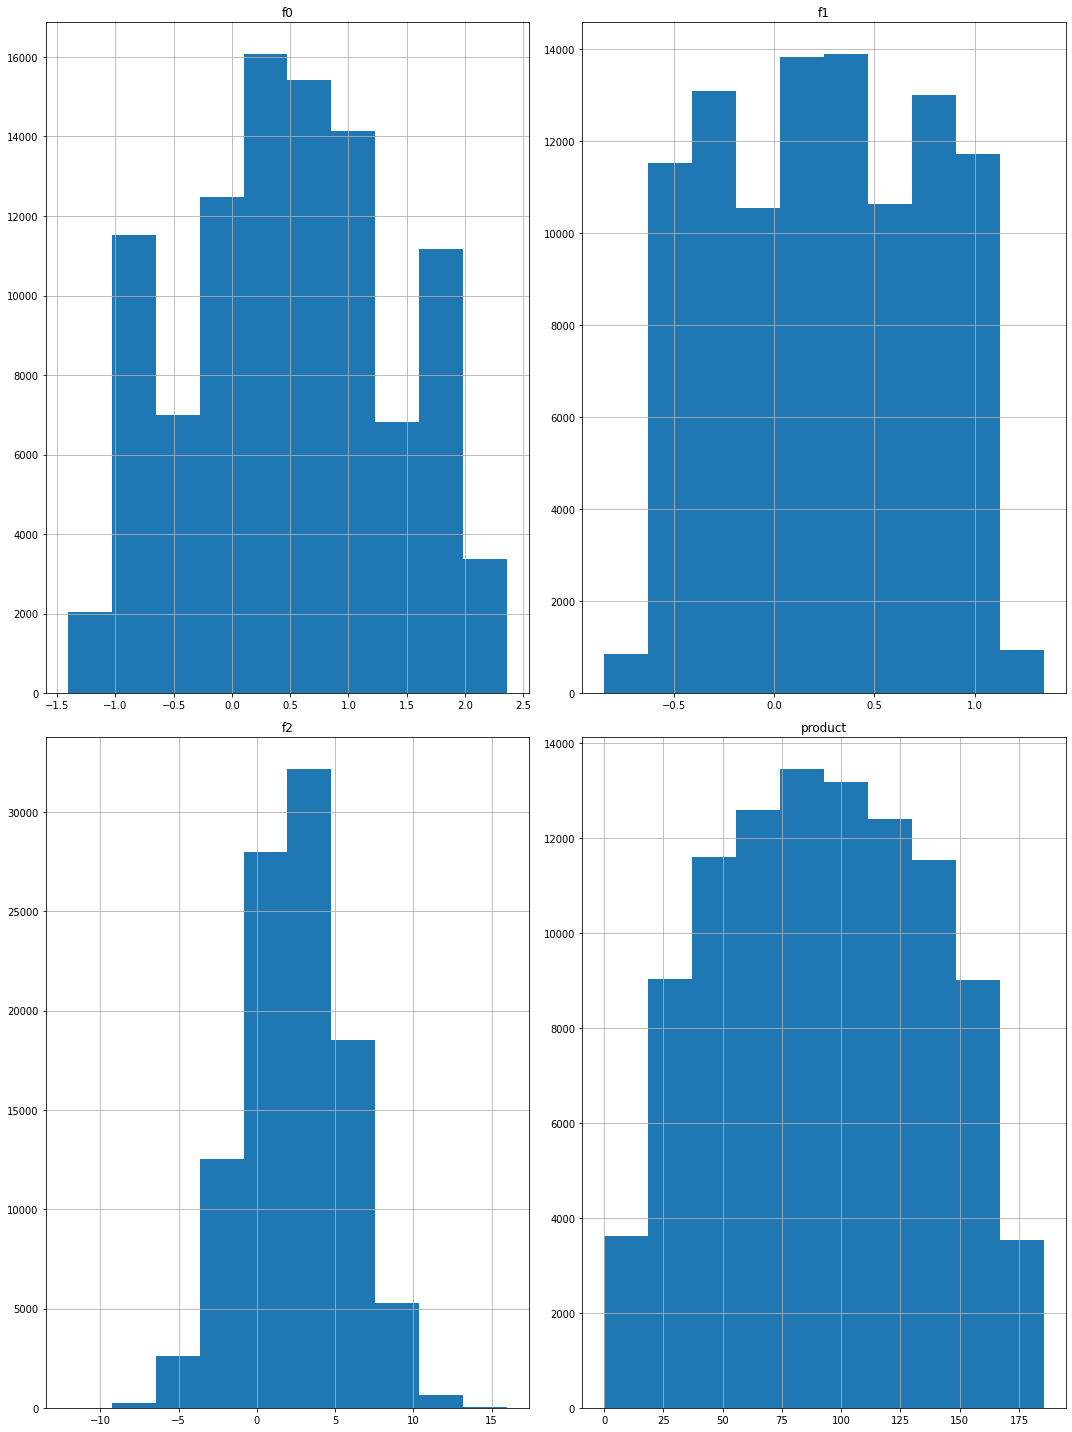

In [15]:
data_0.hist(figsize=(15, 20))
plt.tight_layout() # убираем служебную информацию

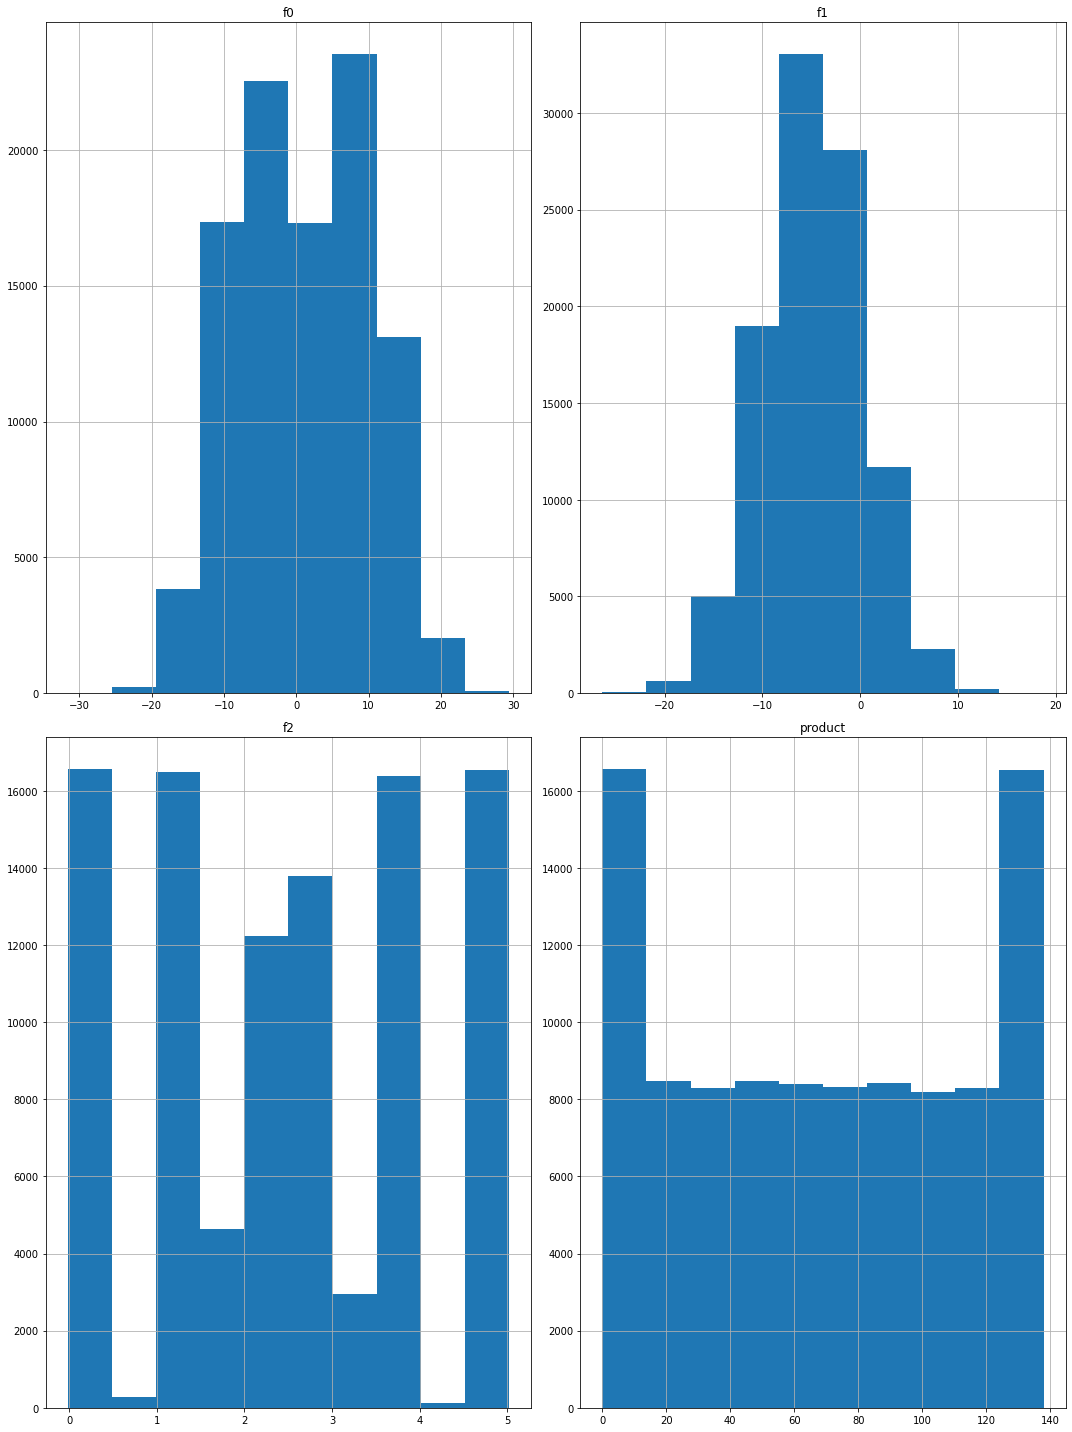

In [16]:
data_1.hist(figsize=(15, 20))
plt.tight_layout() # убираем служебную информацию

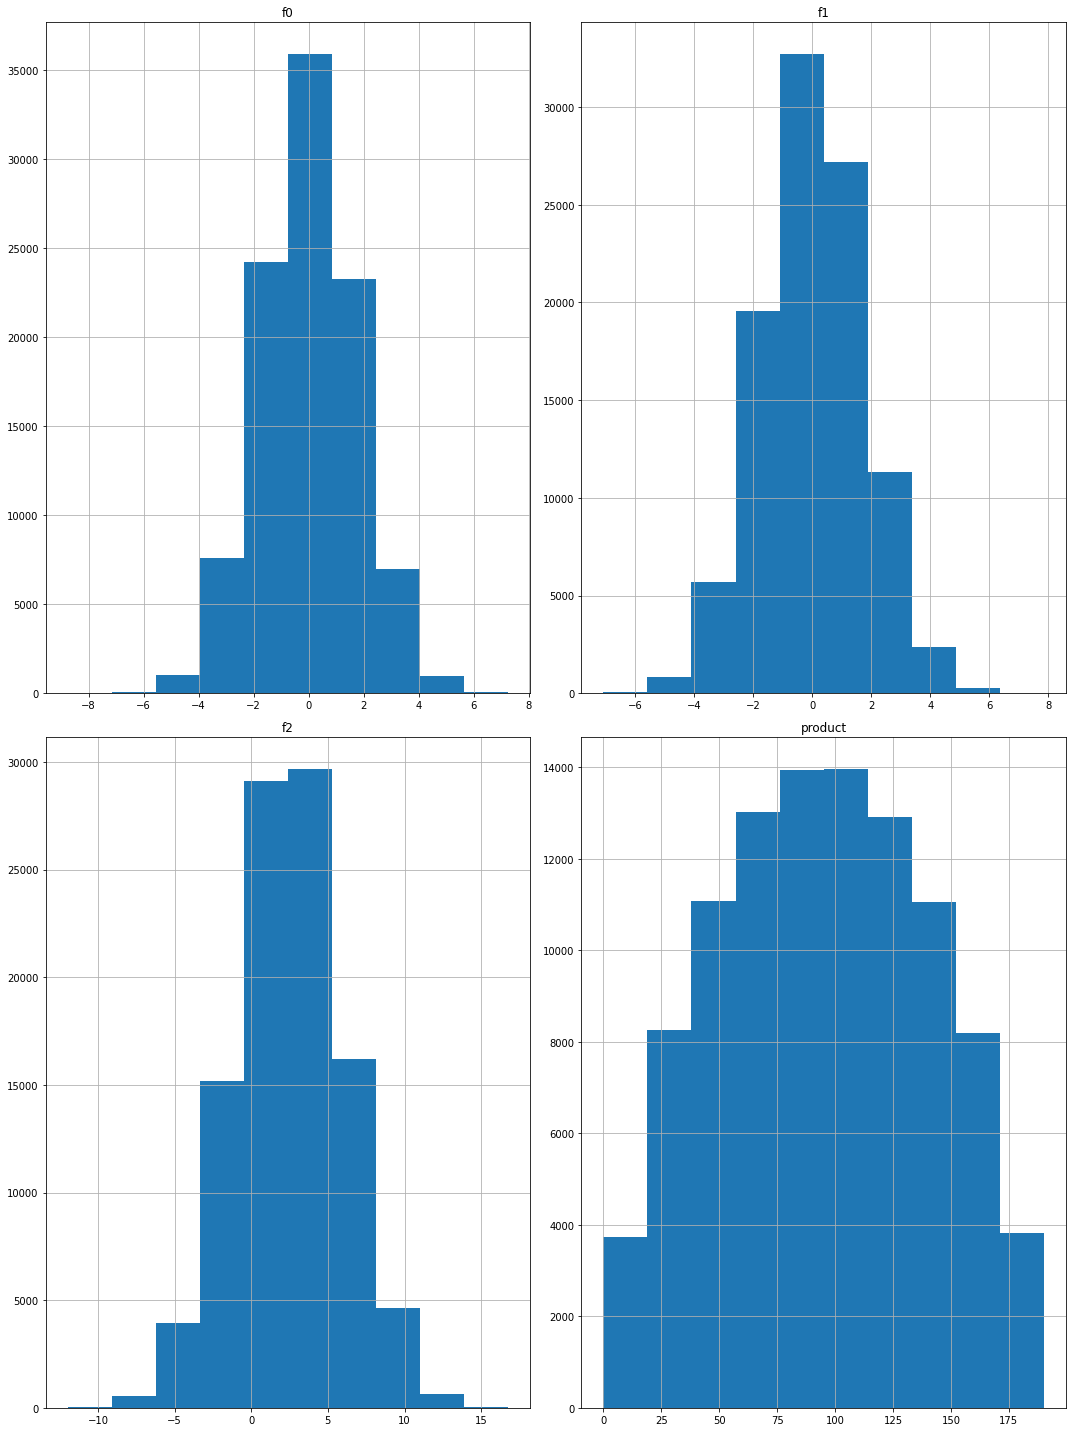

In [17]:
data_2.hist(figsize=(15, 20))
plt.tight_layout() # убираем служебную информацию

#### Удалим id, как лишний признак

In [18]:
dfs = [data_0, data_1, data_2]

In [19]:
for df in dfs:
    for column in df.columns:
        if "id" in column:
            df.drop(column, axis = 1, inplace=True)

In [20]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [21]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [22]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


**Выводы**
После обработки данных необходимо:
- Обучить модель для каждого региона в отдельности используя pipeline
- Посчитать прибыли с учетом рисков
- Сделать необходимые выводы по каждому этапу

## Создадим выборки

In [23]:
target_0 = data_0['product']
features_0 = data_0.drop('product', axis=1)

In [24]:
target_1 = data_1['product']
features_1 = data_1.drop('product', axis=1)

In [25]:
target_2 = data_2['product']
features_2 = data_2.drop('product', axis=1)

In [26]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0,
                                                                                        test_size=0.25, random_state=42)

In [27]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1,
                                                                                        test_size=0.25, random_state=42)

In [28]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2,
                                                                                        test_size=0.25, random_state=42)

### Стандартизируем численные данные

In [29]:
numeric = ['f0', 'f1', 'f2']

In [30]:
scaler_0 = StandardScaler()
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_0.fit(features_train_0[numeric])
scaler_1.fit(features_train_1[numeric])
scaler_2.fit(features_train_2[numeric])
features_train_0[numeric] = scaler_0.transform(features_train_0[numeric])
features_valid_0[numeric] = scaler_0.transform(features_valid_0[numeric])
features_train_1[numeric] = scaler_1.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler_1.transform(features_valid_1[numeric])
features_train_2[numeric] = scaler_2.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler_2.transform(features_valid_2[numeric])



In [31]:
features_train_0.head()

,f0,f1,f2
98980,1.274786,-0.799739,-0.396677
69824,-1.600689,0.234678,-2.169283
9928,-0.323791,1.436297,1.495425
75599,0.439038,0.830679,0.185881
95621,-1.652805,0.761012,0.111734


In [32]:
features_valid_0.head()

,f0,f1,f2
75721,0.113830,-1.605391,-0.119836
80184,0.274030,-1.417818,-1.187407
19864,1.057896,-1.560307,0.371855
76699,1.238466,-0.971658,0.090665
92991,0.480343,-0.450600,0.027088


In [33]:
features_train_1.head()

,f0,f1,f2
98980,0.911229,0.063780,-0.291331
69824,1.640885,1.320793,1.463778
9928,-0.303818,0.859595,0.297952
75599,1.250304,-0.332629,-0.290244
95621,-0.678630,-0.629111,-0.877242


In [34]:
features_valid_1.head()

,f0,f1,f2
75721,0.552191,0.955717,-1.463414
80184,1.710676,1.469288,-0.295155
19864,0.660832,1.089057,1.464310
76699,-0.152665,0.864785,0.882843
92991,1.363467,-0.733052,-1.463970


In [35]:
features_train_2.head()

,f0,f1,f2
98980,-0.343864,-1.338311,0.817572
69824,-0.400431,0.993613,-1.102974
9928,1.004849,-0.923485,-0.576264
75599,-0.784031,0.571573,0.914886
95621,0.619771,0.681588,-0.429467


In [36]:
features_valid_2.head()

,f0,f1,f2
75721,1.218275,-0.966868,0.175298
80184,0.423146,0.434841,0.336007
19864,-1.453162,0.490760,-2.136247
76699,-1.177130,-0.876338,0.739322
92991,1.583978,0.828733,-1.114918


## Обучим модель для каждого региона

### Pегион 0

In [37]:
reg_0 = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              "normalize": [True, False],
              "copy_X": [True, False]
             }
grid_0 = GridSearchCV(reg_0, param_grid = parameters, cv = 3, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_0.fit(features_train_0, target_train_0)

/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error')

In [38]:
preds_0 = grid_0.predict(features_valid_0)

In [39]:
preds_0

array([101.90101715,  78.21777385, 115.26690103, ...,  82.54439653,
        81.82668931,  93.12106221])

In [40]:
rmse_0 = mean_squared_error(target_valid_0, preds_0, squared=False)
rmse_0

37.75660035026169

In [41]:
mean_0 = preds_0.mean()
mean_0

92.3987999065777

### Pегион 1

In [42]:
reg_1 = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              "normalize": [True, False],
              "copy_X": [True, False]
             }
grid_1 = GridSearchCV(reg_1, param_grid = parameters, cv = 3, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_1.fit(features_train_1, target_train_1)

/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipelin

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error')

In [43]:
preds_1 = grid_1.predict(features_valid_1)

In [44]:
rmse_1 = mean_squared_error(target_valid_1, preds_1, squared=False)
rmse_1

0.8902801001028784

In [45]:
mean_1 = preds_1.mean()
mean_1

68.7128780391376

### Pегион 2

In [46]:
reg_2 = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              "normalize": [True, False],
              "copy_X": [True, False]
             }
grid_2 = GridSearchCV(reg_2, param_grid = parameters, cv = 3, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_2.fit(features_train_2, target_train_2)

/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipelin

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error')

In [47]:
preds_2 = grid_2.predict(features_valid_2)

In [48]:
rmse_2 = mean_squared_error(target_valid_2, preds_2, squared=False)
rmse_2

40.145872311342174

In [49]:
mean_2 = preds_2.mean()
mean_2

94.77102387765939

**Выводы**

Среднее предсказанное значение выше всего во втором регионе

## Подготовка к расчету прибыли

### Преобразовываем предсказания в Series

In [50]:
predictions_0 = pd.Series(preds_0, index = target_valid_0.index)
predictions_1 = pd.Series(preds_1, index = target_valid_1.index)
predictions_2 = pd.Series(preds_2, index = target_valid_2.index)

### Ключевые значения для расчетов

In [51]:
budget = 10000000000
income =  450000
total_fields = 500
selected_fields = 200

### Расчитаем минимальный объем сырья для безубыточной разработки скважин

In [52]:
min_volume = budget/income/selected_fields
min_volume

111.11111111111111

### Расчитаем средний объем в каждом регионе

In [53]:
avg_volume_0 = data_0['product'].mean()
avg_volume_0

92.50000000000001

In [54]:
avg_volume_1 = data_1['product'].mean()
avg_volume_1

68.82500000000002

In [55]:
avg_volume_2 = data_2['product'].mean()
avg_volume_2

95.00000000000004

**Выводы**
Средний объем продукта в скважинах ниже безубыточного

## Функция расчета прибыли

In [56]:

    
def revenue(t, p):
    df_tmp = pd.concat([t, p], axis=1)
    df_tmp.columns = ['t', 'p']
    df_tmp = df_tmp.sort_values(by='p', ascending=False).head(selected_fields)
    return df_tmp['t'].sum() * income - budget
    

In [57]:
net_rev_0 = revenue(target_0, predictions_0)
net_rev_0

3359141114.462179

In [58]:
net_rev_1 = revenue(target_1, predictions_1)
net_rev_1

2415086696.681511

In [59]:
net_rev_2 = revenue(target_2, predictions_2)
net_rev_2

2598571759.374111

## Напишем bootstrap функцию

In [60]:
bootstrap_samples = 1000
alpha = 0.95
state = np.random.RandomState(42)

In [61]:
def bootstrap(target, prediction):
    revenue_bootstrap = []
    for i in range(bootstrap_samples):
        ##prediction_subsample = pd.Series(prediction).sample(total_fields, replace=True, random_state=state,)
        ##target_subsample = pd.Series(target, index=prediction_subsample.index)
        target_subsample = target.sample(total_fields, replace=True, random_state=state)
        prediction_subsample = prediction[target_subsample.index] 
        revenue_bootstrap.append(revenue(target_subsample, prediction_subsample))
    revenue_bootstrap = pd.Series(revenue_bootstrap)
    revenue_bootstrap_mean = revenue_bootstrap.mean()
    risk = np.sum(revenue_bootstrap < 0).mean()
    upper = revenue_bootstrap.quantile(0.975)
    lower = revenue_bootstrap.quantile(0.025)
    return 'Средняя прибыль {} Верхняя граница {} Нижняя граница {} Риск {}'.format(revenue_bootstrap_mean, 
                                                                                    upper, lower, risk)

    

  
    
    

In [62]:
bootstrap(target_valid_0, predictions_0)

'Средняя прибыль 399575478.05422974 Верхняя граница 897460327.7178793 Нижняя граница -110467895.33197226 Риск 60.0'

In [63]:
bootstrap(target_valid_1, predictions_1)

'Средняя прибыль 452576594.2909005 Верхняя граница 830146313.2647407 Нижняя граница 52309409.80273462 Риск 9.0'

In [64]:
bootstrap(target_valid_2, predictions_2)

'Средняя прибыль 378705903.65973765 Верхняя граница 907923483.2210629 Нижняя граница -127779434.98830414 Риск 75.0'

**Вывод**

С учетом всех рисков и подсчетов приьыли предлагаю разрабатывать второй регион (data1) .Верхняя граница прибыли выше в третьем(data_2), но и риски там выше, а средняя прибль ниже.